# Predicting house prices using regression model on the Boston Housing Price dataset

As you can see, we have 404 training samples and 102 test samples. The data comprises 13 features. The 13 features in the input data are as follow:
1. Per capita crime rate.
2. Proportion of residential land zoned for lots over 25,000 square feet.
3. Proportion of non-retail business acres per town.
4. Charles River dummy variable (= 1 if tract bounds river; 0 otherwise). 5. Nitric oxides concentration (parts per 10 million).
6. Average number of rooms per dwelling.
7. Proportion of owner-occupied units built prior to 1940.
8. Weighted distances to five Boston employment centres.
9. Index of accessibility to radial highways.
10. Full-value property-tax rate per $10,000.
11. Pupil-teacher ratio by town.
12. 1000 * (Bk - 0.63) ** 2 where Bk is the proportion of Black people by town. 13. % lower status of the population.

In [1]:
# imports

# keras imports
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing import sequence
from keras.datasets import boston_housing
from keras.utils.np_utils import to_categorical


# general imports
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown #just to display markdown

Using TensorFlow backend.


In [2]:

# Loading the Boston housing dataset
(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

# Taking a look at the data
print ("before data preprocessing")
print('input_train shape:', train_data.shape)
print('input_test shape:', test_data.shape, "\n")

print("\nthe boston housing price dataset's 1 sample input data\n")
print(train_data[:1]) 

print("\nthe boston housing price dataset's 2 lables")
print(train_targets[:2])

# Preparing the data

# data normalization
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

# Building our network
def build_model():
    # Because we will need to instantiate
    # the same model multiple time,
    # we use a function to construct it.
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

57344/57026 [==============================] - 0s 8us/step
before data preprocessing
input_train shape: (404, 13)
input_test shape: (102, 13) 


the boston housing price dataset's 1 sample input data

[[  1.23247   0.        8.14      0.        0.538     6.142    91.7
    3.9769    4.      307.       21.      396.9      18.72   ]]

the boston housing price dataset's 2 lables
[15.2 42.3]


## Validating our approach using K-fold validation

In [3]:
k= 4
num_val_samples = len(train_data) // k 
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],axis=0)
    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # Evaluate the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)
print ("Validation MAE scores for successive 'folds'".format(np.mean(all_scores)))

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
Validation MAE scores for successive 'folds'


## Saving the validation logs at each fold

In [4]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
axis=0)
    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


## Building the history of successive mean K-fold validation scores & plotting

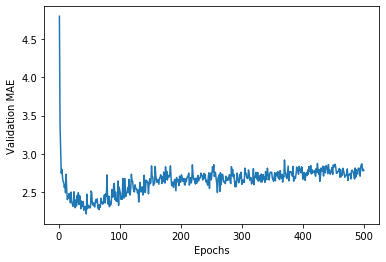

In [5]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
    
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

## Plotting validation scores - excluding the first 10 data points

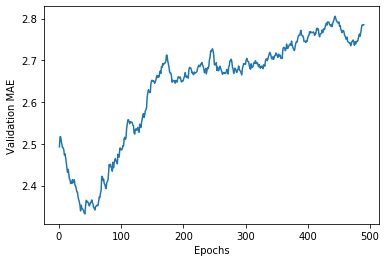

In [6]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points
smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

## Training the final model

In [7]:
# Get a fresh, compiled model.
model = build_model()
# Train it on the entirety of the data.
model.fit(train_data, train_targets,epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 678us/step


##  final result

In [8]:
print ("Final MAE on test data :{}".format(test_mae_score))

Final MAE on test data :2.672602335611979
